## This is the simple method of feature relation
### Status update: This method can get LB 0.6 up, if you solve the GPU timeout issue and find the great threshold of distance
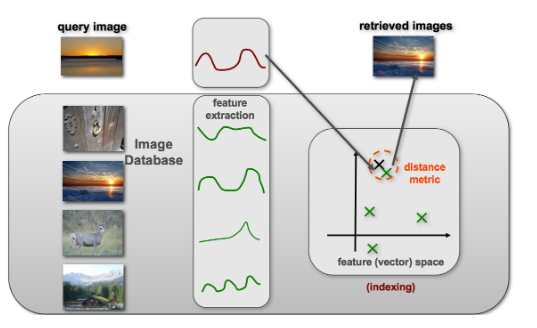image reference : https://github.com/pochih/CBIR
* I use the 20% training data to demo this method 
* Using pre-trained Efficient-B0 model to be feature extractor
* Extract all image features and using euclidean distance to find the similarity image
* P.S this notebook can't commit the result, in this competition, GPU limit only 2 hours, if you submit this notebook, it will exceed the time limit

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import torch
import numpy as np
import cupy as cp

from torchvision import transforms
from PIL import Image
from tqdm.notebook import tqdm
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### Install EfficientNet Pytorch offline
* https://www.kaggle.com/hmendonca/efficientnet-pytorch

In [ ]:
! pip install "../input/efficientnet-pytorch/EfficientNet-PyTorch/EfficientNet-PyTorch-master/"

### Load efficientnet b0 pretrained model by imageNet

In [ ]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_name('efficientnet-b0')
model.load_state_dict(torch.load("../input/efficientnet-pytorch/efficientnet-b0-08094119.pth"))
model = model.eval()

### Define image featrue extract Dataset

In [ ]:
from torch.utils.data import Dataset, DataLoader
class ShopeeDataset(Dataset):
    def __init__(self, anotation, transforms):
        self.anotation = anotation
        self.transforms = transforms
        
    def __len__(self):
        return len(self.anotation)
    
    def __getitem__(self, idx):
        
        post_id, img_id = self.anotation.loc[idx,['posting_id','image']].values
        img_path = "../input/shopee-product-matching/train_images/"+img_id
        img = Image.open(img_path)
        img = self.transforms(img)
        return img, post_id

### Load train files

In [ ]:
train = pd.read_csv('/kaggle/input/shopee-product-matching/train.csv')
### I only use 20% data to demo this method
train = train[:int(len(train)*0.2)] 

### Extract all test image feature
* First we extract all image feature by pre-train efficient-b0 as our retrival database
* Set the base image then find the distance to all the image in database

In [ ]:
tfms = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),])

data = ShopeeDataset(anotation = train, transforms=tfms)

batch_size=64
data_loader = DataLoader(dataset=data, batch_size=batch_size, shuffle=False)

In [ ]:
device = torch.device("cuda")
model = model.to(device)

In [ ]:
data_feature = np.zeros((len(train),1280))
post_id_list = []
for i, (x_input, post_input) in enumerate(tqdm(data_loader)):
    features = model.extract_features(x_input.to(device))
    feature_vec = torch.nn.AdaptiveAvgPool2d(1)(features).cpu().view(-1,1280).detach().numpy()
    data_feature[i * batch_size:(i+1) * batch_size] = feature_vec
    post_id_list += post_input
    del x_input, post_input, features

In [ ]:
feature_data = pd.DataFrame({"post_id":post_id_list,"feature":data_feature.tolist()})

In [ ]:
feature_data.head()

### Find the feature distance between base image and related image
* Using simple euclidean distance
* Set the distance lower than 14 (you can define by yourself and find the best threshold by CV calculate)

In [ ]:
post_id_sub_list = []
match_id_list = []
for i in tqdm(range(len(feature_data))):

    post_id, fea_id = feature_data.loc[i,['post_id','feature']].values
    #match_temp_id = ""
    #score_np = np.linalg.norm(data_feature - fea_id, ord=2, axis=1.)
    #score_np = np.dot(fea_id, data_feature.T)
    score_np = cp.sum((data_feature-fea_id)**2,axis = 1)
    idx_relate = np.where(score_np<30)
    
    temp_str = " ".join(np.array(post_id_list)[idx_relate[0]].tolist())
    
    post_id_sub_list.append(post_id)
    match_id_list.append(temp_str)

### Efficient relate result

In [ ]:
submission1 = pd.DataFrame()
submission1['posting_id'] = post_id_sub_list
submission1['matches'] = match_id_list

In [ ]:
submission1.head()

In [ ]:
submission1.head()

### Plot the image to check the model result
* Let's plot 10 related image to check the model performance

In [ ]:
def plot_image_list(img_list, post_id, match_list):
    """ Function to display row of image slices """
    fig, axes = plt.subplots(1, len(img_list),figsize=(len(img_list)*5, 5))
    fig.suptitle('Query Image = [{}], Match Image = [{}]'.format(post_id, ",".join(match_list)), fontsize=16)
    for i, img in enumerate(img_list):
        axes[i].imshow(img)

* We only use 20% training data, if we use full training data, we can find more relate image.

In [ ]:
import matplotlib.pyplot as plt
train_path = "../input/shopee-product-matching/train_images/"
have_relate_img = submission1[submission1['posting_id']!=submission1['matches']].reset_index(drop=True)
for i in np.random.choice(len(have_relate_img), 20):
    query_id, match_id = have_relate_img.loc[i,['posting_id','matches']].values
    match_list = match_id.split(" ")
    plt_array=[]
    for j in match_list:
        img_name = train[train['posting_id']==j]['image'].values[0]
        img_path = train_path+img_name
        img = Image.open(img_path)
        plt_array.append(img)
    plot_image_list(plt_array, query_id, match_list)

### Conclusion
* We need to extract all test image features, so submit need large time to extract
* This notebook can't submit the test result, because there are about 70000 test image, submit time will exceed the limit (2Hours)
* This method can get LB 0.6 up, if you solve the GPU timeout issue and find the great threshold of distance (my current score)

### Next step
* Solve the time limit (using some algorithm to reduce inference time)
* Using training set to re-train the better feature extractor